<a href="https://colab.research.google.com/github/dnlgnwn-wq/Prediksi-model-bmw_ANN/blob/main/Prediksi_Mobil_BMW_ANN_Daniel_UTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT LIBRARY

In [1]:
# ==================================================================
# CELL 1: IMPORT LIBRARY
# ==================================================================
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt

# Metrics & Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

print("✅ Library berhasil di-import.")

✅ Library berhasil di-import.


LOAD DATA & FEATURE ENGINEERING

In [3]:
# ==================================================================
# CELL 2: LOAD DATA & FEATURE ENGINEERING (BMW DATASET)
# ==================================================================
try:
    df = pd.read_csv("/content/bmw.csv", sep=';')
    print(f"✅ Data dimuat: {df.shape[0]} baris.")
except FileNotFoundError:
    print("❌ ERROR: File '/content/bmw.csv' belum diupload!")

# 1. Bersihkan Duplikat
df = df.drop_duplicates()

# 2. Feature Engineering (opsional – contoh tambahan fitur untuk model)
#    Anda bisa menambah atau menghapus sesuai kebutuhan
df['price_per_year'] = df['price'] / (2025 - df['year'] + 1)   # Harga relatif umur mobil
df['mileage_per_year'] = df['mileage'] / (2025 - df['year'] + 1) # Rata-rata pemakaian tahunan

# 3. Tentukan Fitur (X) dan Target (y)
X = df[['year', 'price', 'transmission', 'mileage', 'fuelType', 'tax', 'mpg', 'engineSize',
        'price_per_year', 'mileage_per_year']]
y = df['model']

# 4. Encode label menjadi angka
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("✅ Feature Engineering selesai. Contoh fitur:")
print(X.head())

print("\nContoh encoding label (model):")
print(list(zip(y[:9], y_encoded[:9])))

✅ Data dimuat: 10781 baris.
✅ Feature Engineering selesai. Contoh fitur:
   year  price transmission  mileage fuelType  tax   mpg  engineSize  \
0  2014  11200    Automatic    67068   Diesel  125  57.6         2.0   
1  2018  27000    Automatic    14827   Petrol  145  42.8         2.0   
2  2016  16000    Automatic    62794   Diesel  160  51.4         3.0   
3  2017  12750    Automatic    26676   Diesel  145  72.4         1.5   
4  2014  14500    Automatic    39554   Diesel  160  50.4         3.0   

   price_per_year  mileage_per_year  
0      933.333333       5589.000000  
1     3375.000000       1853.375000  
2     1600.000000       6279.400000  
3     1416.666667       2964.000000  
4     1208.333333       3296.166667  

Contoh encoding label (model):
[(' 5 Series', np.int64(4)), (' 6 Series', np.int64(5)), (' 5 Series', np.int64(4)), (' 1 Series', np.int64(0)), (' 7 Series', np.int64(6)), (' 5 Series', np.int64(4)), (' 5 Series', np.int64(4)), (' 2 Series', np.int64(1)), (' 4 Seri

DATA PREPROCESSING

In [5]:
# ==================================================================
# CELL 3: DATA PREPROCESSING
# ==================================================================

# 1. Encode Label (Ubah teks cuaca jadi angka)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)

# Tambahkan One-Hot Encoding untuk kolom kategorikal dalam X
X_encoded = pd.get_dummies(X, columns=['transmission', 'fuelType'], drop_first=True)

# 2. Balancing Data dengan SMOTE (Agar data seimbang)
print("⏳ Sedang menyeimbangkan data dengan SMOTE...")
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y_encoded)

# 3. Normalisasi / Scaling (WAJIB untuk ANN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# 4. Split Train & Test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_resampled, test_size=0.2, random_state=42
)

print(f"✅ Siap Training. Data Latih: {X_train.shape[0]}, Data Uji: {X_test.shape[0]}")

⏳ Sedang menyeimbangkan data dengan SMOTE...
✅ Siap Training. Data Latih: 46732, Data Uji: 11684


MEMBANGUN MODEL ANN

In [6]:
# ==================================================================
# CELL 4: MEMBANGUN MODEL ANN
# ==================================================================
input_dim = X_train.shape[1]

model = Sequential([
    # Hidden Layer 1
    Dense(128, activation='relu', input_shape=(input_dim,)),
    BatchNormalization(),
    Dropout(0.3),

    # Hidden Layer 2
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Hidden Layer 3
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    # Output Layer
    Dense(num_classes, activation='softmax')
])

# Optimizer Learning Rate
opt = Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 24)             │           792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,944 (54.47 KB)

 Trainable params: 13,496 (52.72 KB)

 Non-trainable params: 448 (1.75 KB)

TRAINING PROCESS

In [7]:
# ==================================================================
# CELL 5: TRAINING PROCESS
# ==================================================================
print("\n Memulai Training...")
start_train = time.time() # <--- Mulai stopwatch training

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=150,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

end_train = time.time() # <--- Stop stopwatch training
training_time = end_train - start_train

print(f"\n✅ Training Selesai! Waktu Training: {training_time:.4f} detik")


 Memulai Training...
Epoch 1/150
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.3567 - loss: 2.1342 - val_accuracy: 0.6014 - val_loss: 1.1176 - learning_rate: 0.0010
Epoch 2/150
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5281 - loss: 1.3452 - val_accuracy: 0.6432 - val_loss: 0.9895 - learning_rate: 0.0010
Epoch 3/150
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5666 - loss: 1.2156 - val_accuracy: 0.6683 - val_loss: 0.9077 - learning_rate: 0.0010
Epoch 4/150
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5977 - loss: 1.1407 - val_accuracy: 0.7109 - val_loss: 0.8204 - learning_rate: 0.0010
Epoch 5/150
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6309 - loss: 1.0649 - val_accuracy: 0.7105 - val_loss: 0.8157 - learning_rate: 0.0010
Epoch 6/150
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6483 - loss: 1.0201 - val_accuracy: 0.7374 - val_loss: 0.7444 - learning_rate: 0.0010
Epoch 7/150
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 4s 3m

VISUALISASI HISTORY

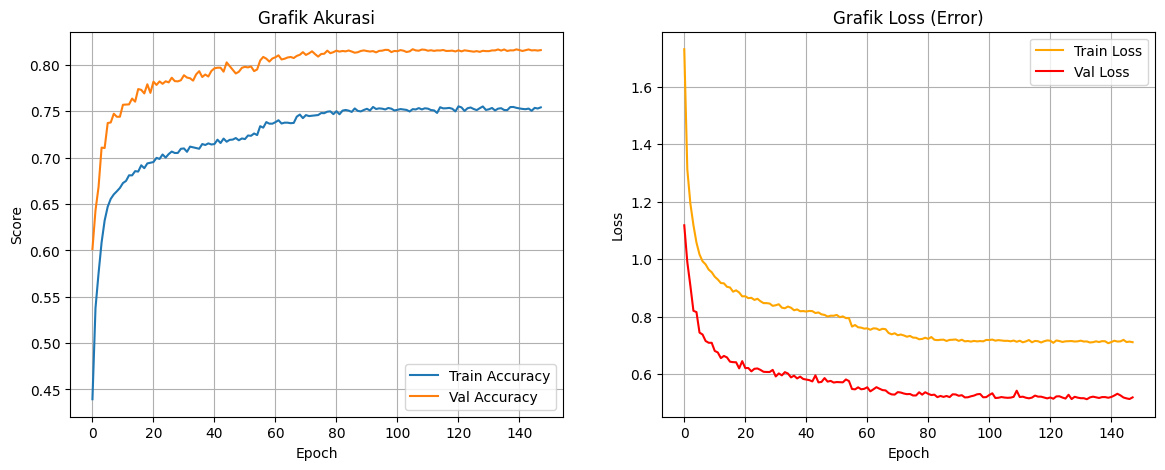

In [8]:
# ==================================================================
# CELL 6: VISUALISASI HISTORY
# ==================================================================
plt.figure(figsize=(14, 5))

# Grafik Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Grafik Akurasi')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# Grafik Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='orange')
plt.plot(history.history['val_loss'], label='Val Loss', color='red')
plt.title('Grafik Loss (Error)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

EVALUASI

🔍 Sedang melakukan evaluasi...
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

📊 LAPORAN PERFORMA MODEL ANN
⏱️ Waktu Training  : 607.1496 detik
⏱️ Waktu Eksekusi  : 1.2589 detik (untuk 11684 data)
🎯 Akurasi (Acc)   : 81.5731%
📈 AUC Score       : 0.9895

Detailed Classification Report:
              precision    recall  f1-score   support

    1 Series     0.6089    0.6509    0.6292       507
    2 Series     0.5695    0.4456    0.5000       478
    3 Series     0.5965    0.3232    0.4192       526
    4 Series     0.5147    0.4656    0.4889       451
    5 Series     0.6950    0.5857    0.6357       502
    6 Series     0.7458    0.8665    0.8016       457
    7 Series     0.8454    0.8825    0.8635       502
    8 Series     0.8378    0.8812    0.8589       463
          M2     0.8936    0.9858    0.9374       494
          M3     0.9533    1.0000    0.9761       490
          M4     0.8857    0.8784    0.8820       485
          M5     0.9676    0.9713    0.9694       522
          M6     

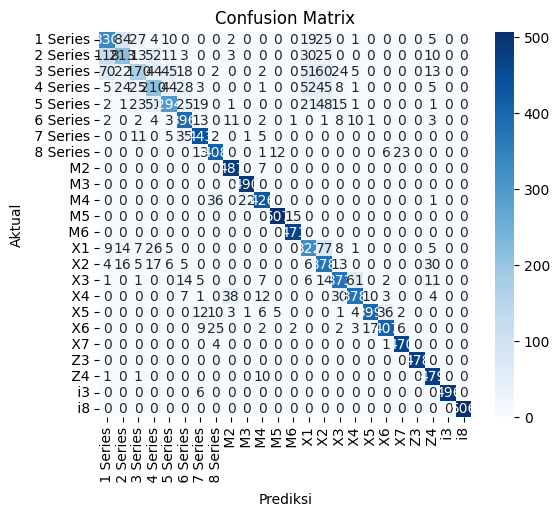

In [9]:
# ==================================================================
# CELL 7: EVALUASI PERFORMA & AUC SCORE
# ==================================================================
print("🔍 Sedang melakukan evaluasi...")

# 1. Hitung Waktu Eksekusi (Inference Time)
start_pred = time.time()
y_pred_proba = model.predict(X_test)     # Output probabilitas
y_pred = np.argmax(y_pred_proba, axis=1) # Output kelas (0,1,2...)
end_pred = time.time()

execution_time = end_pred - start_pred

# 2. Hitung Metrics
acc = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')

# 3. Tampilkan Laporan
print("\n" + "="*40)
print("📊 LAPORAN PERFORMA MODEL ANN")
print("="*40)
print(f"⏱️ Waktu Training  : {training_time:.4f} detik")
print(f"⏱️ Waktu Eksekusi  : {execution_time:.4f} detik (untuk {len(X_test)} data)")
print(f"🎯 Akurasi (Acc)   : {acc * 100:.4f}%") # <--- Diubah ke 4 angka
print(f"📈 AUC Score       : {auc_score:.4f}")
print("="*40)

print("\nDetailed Classification Report:")
# PERUBAHAN ADA DI SINI: digits=4
print(classification_report(y_test, y_pred, target_names=le.classes_, digits=4))

# 4. Confusion Matrix
plt.figure(figsize=(6,5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.show()

INPUT MANUAL DARI USER

In [14]:
# ==================================================================
# CELL 8: PREDIKSI MANUAL (BMW)
# ==================================================================
print("\n🚗 === SYSTEM PREDIKSI MODEL MOBIL BMW ===")

try:
    # === Input manual dari user ===
    year = int(input("1. Tahun Mobil                : "))
    price = float(input("2. Harga Mobil (£)           : "))
    mileage = float(input("3. Jarak Tempuh (mileage)    : "))
    tax = float(input("4. Pajak Kendaraan (£)       : "))
    mpg = float(input("5. Konsumsi BBM (mpg)        : "))
    engineSize = float(input("6. Ukuran Mesin (engineSize) : "))
    transmission = input("7. Transmisi (Manual/Auto/Semi-Auto): ")
    fuelType = input("8. Jenis Bahan Bakar (Petrol/Diesel/Hybrid/Electric/Other): ")

    # === Feature Engineering pada input ===
    price_per_year = price / (2025 - year + 1)
    mileage_per_year = mileage / (2025 - year + 1)

    # === Buat DataFrame input ===
    input_df = pd.DataFrame([{
        'year': year,
        'price': price,
        'mileage': mileage,
        'tax': tax,
        'mpg': mpg,
        'engineSize': engineSize,
        'transmission': transmission,
        'fuelType': fuelType,
        'price_per_year': price_per_year,
        'mileage_per_year': mileage_per_year
    }])

    # === Encoding kategori sama seperti training ===
    input_encoded = pd.get_dummies(input_df)
    input_encoded = input_encoded.reindex(columns=X_encoded.columns, fill_value=0)

    # === Normalisasi (scaling) ===
    input_scaled = scaler.transform(input_encoded)

    # === Prediksi ===
    start_manual = time.time()
    pred_proba = model.predict(input_scaled)
    end_manual = time.time()

    pred_index = np.argmax(pred_proba)
    pred_label = le.inverse_transform([pred_index])[0]
    confidence = pred_proba[0][pred_index] * 100

    # === Output hasil ===
    print("\n" + "="*40)
    print(f"🚘 HASIL PREDIKSI MODEL BMW: {pred_label.upper()}")
    print(f"📊 Tingkat Keyakinan      : {confidence:.2f}%")
    print(f"⏱️ Waktu Proses           : {(end_manual - start_manual):.6f} detik")
    print("="*40)

except Exception as e:
    print(f"\n⚠️ Input error: {e}")


🚗 === SYSTEM PREDIKSI MODEL MOBIL BMW ===
1. Tahun Mobil                : 2016
2. Harga Mobil (£)           : 20000
3. Jarak Tempuh (mileage)    : 2000
4. Pajak Kendaraan (£)       : 120
5. Konsumsi BBM (mpg)        : 30.0
6. Ukuran Mesin (engineSize) : 3.5
7. Transmisi (Manual/Auto/Semi-Auto): Semi-Auto
8. Jenis Bahan Bakar (Petrol/Diesel/Hybrid/Electric/Other): Hybrid
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

🚘 HASIL PREDIKSI MODEL BMW:  3 SERIES
📊 Tingkat Keyakinan      : 44.06%
⏱️ Waktu Proses           : 0.060075 detik


PERBANDINGAN AKURASI 4 MODEL

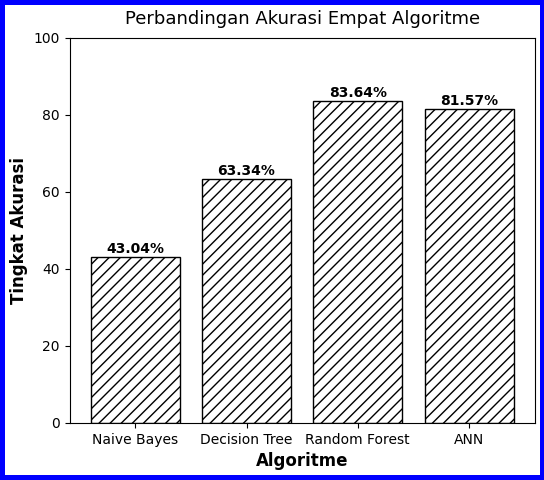

In [15]:
model_names = ['Naive Bayes', 'Decision Tree', 'Random Forest', 'ANN']
accuracy_values = [43.0374, 63.3430, 83.6357, 81.5731]

plt.figure(figsize=(6, 5))
bars = plt.bar(model_names, accuracy_values, color='white', edgecolor='black', hatch='///')

for bar, acc in zip(bars, accuracy_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f"{acc:.2f}%", ha='center', fontsize=10, fontweight='bold')

plt.ylim(0, 100)
plt.ylabel("Tingkat Akurasi", fontsize=12, fontweight='bold')
plt.xlabel("Algoritme", fontsize=12, fontweight='bold')
plt.title("Perbandingan Akurasi Empat Algoritme", fontsize=13, pad=10)

plt.gca().set_facecolor('white')
plt.grid(False)
plt.gcf().patch.set_edgecolor('blue')
plt.gcf().patch.set_linewidth(6)

plt.show()

PERBANDINGAN NILAI PRECISION

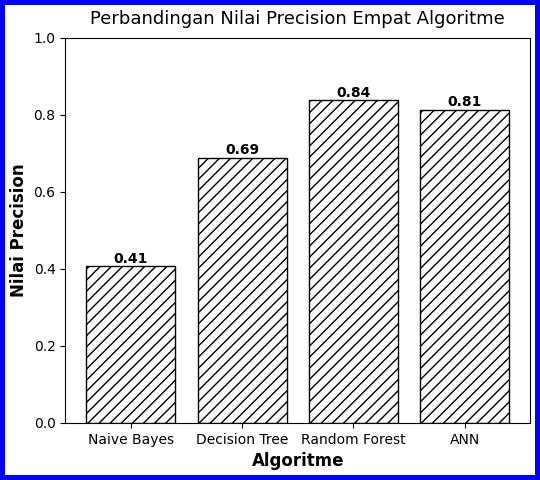

In [16]:
precision_values = [0.4060, 0.6879, 0.8372, 0.8121]

plt.figure(figsize=(6, 5))
bars = plt.bar(model_names, precision_values, color='white', edgecolor='black', hatch='///')

for bar, val in zip(bars, precision_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{val:.2f}", ha='center', fontsize=10, fontweight='bold')

plt.ylim(0, 1)
plt.ylabel("Nilai Precision", fontsize=12, fontweight='bold')
plt.xlabel("Algoritme", fontsize=12, fontweight='bold')
plt.title("Perbandingan Nilai Precision Empat Algoritme", fontsize=13, pad=10)

plt.gca().set_facecolor('white')
plt.grid(False)
plt.gcf().patch.set_edgecolor('blue')
plt.gcf().patch.set_linewidth(6)

plt.show()

PERBANDINGAN NILAI RECALL

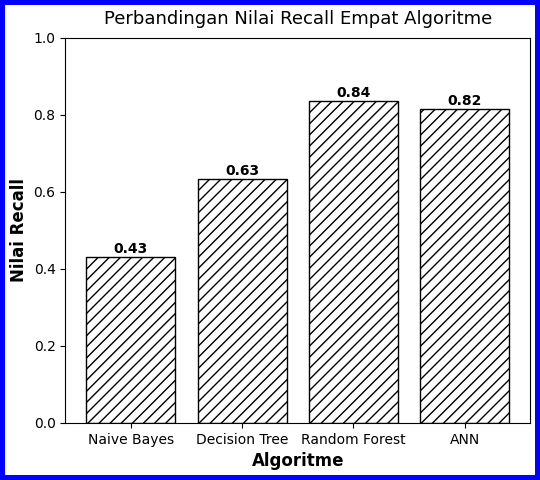

In [17]:
recall_values = [0.4304, 0.6334, 0.8364, 0.8157]

plt.figure(figsize=(6, 5))
bars = plt.bar(model_names, recall_values, color='white', edgecolor='black', hatch='///')

for bar, val in zip(bars, recall_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{val:.2f}", ha='center', fontsize=10, fontweight='bold')

plt.ylim(0, 1)
plt.ylabel("Nilai Recall", fontsize=12, fontweight='bold')
plt.xlabel("Algoritme", fontsize=12, fontweight='bold')
plt.title("Perbandingan Nilai Recall Empat Algoritme", fontsize=13, pad=10)

plt.gca().set_facecolor('white')
plt.grid(False)
plt.gcf().patch.set_edgecolor('blue')
plt.gcf().patch.set_linewidth(6)

plt.show()

PERBANDINGAN NILAI F1-SCORE

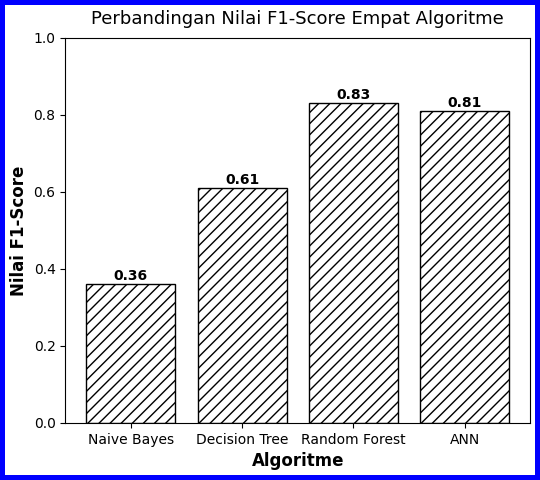

In [18]:
f1_values = [0.3609, 0.6102, 0.8301, 0.8100]

plt.figure(figsize=(6, 5))
bars = plt.bar(model_names, f1_values, color='white', edgecolor='black', hatch='///')

for bar, val in zip(bars, f1_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{val:.2f}", ha='center', fontsize=10, fontweight='bold')

plt.ylim(0, 1)
plt.ylabel("Nilai F1-Score", fontsize=12, fontweight='bold')
plt.xlabel("Algoritme", fontsize=12, fontweight='bold')
plt.title("Perbandingan Nilai F1-Score Empat Algoritme", fontsize=13, pad=10)

plt.gca().set_facecolor('white')
plt.grid(False)
plt.gcf().patch.set_edgecolor('blue')
plt.gcf().patch.set_linewidth(6)

plt.show()

HASIL AKHIR 4 MODEL

In [20]:
# Data hasil akhir dari empat model
data = {
    'Algoritma': ['Naive Bayes', 'Decision Tree', 'Random Forest', 'ANN'],
    'Akurasi (%)': ['43,04 %', '63,34 %', '83,64 %', '81,57 %'],
    'Precision': [0.41, 0.69, 0.84, 0.81],
    'Recall': [0.43, 0.63, 0.84, 0.82],
    'F1-Score': [0.36, 0.61, 0.83, 0.81],
    '(Total Data) Support': [11684, 11684, 11684, 11684],
    'Waktu Eksekusi (s)': ['0.0428 detik', '0.0097 detik', '2.0477 detik', '1.2589 detik']
}

# Membuat DataFrame
df = pd.DataFrame(data)

# Nama Kolom
df.columns = [
    "Algoritma",
    "Akurasi (%)",
    "Precision",
    "Recall",
    "F1-Score",
    "Support",
    "Waktu Eksekusi (s)"
]

VISUALISASI TABEL

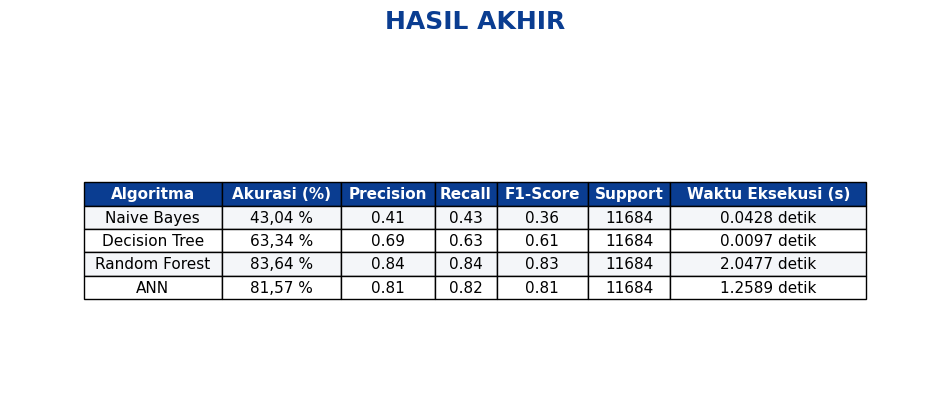

In [21]:
fig, ax = plt.subplots(figsize=(12, 3.8))   # ✅ dibuat lebih lebar agar kolom muat
ax.axis('off')

# Header Judul
plt.text(
    0.5, 1.25, "HASIL AKHIR",
    ha='center', va='center',
    fontsize=18, fontweight='bold', color='#0A3D91'
)

# Membuat tabel
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    loc='center'
)

# Mengatur ukuran tulisan & scaling
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.3, 1.4)        # ✅ kolom lebih lebar & tidak rapat

# Mengatur lebar kolom secara manual (BIAR RAPIH)
# Semakin besar angkanya → semakin lebar kolomnya
col_widths = {
    0: 0.16,   # Algoritma
    1: 0.10,   # Akurasi
    2: 0.10,   # Precision
    3: 0.10,   # Recall
    4: 0.10,   # F1-Score
    5: 0.14,   # Support
    6: 0.20    # Waktu Eksekusi
}

for col, width in col_widths.items():
    table.auto_set_column_width(col)   # aktifkan auto width
    table._cells[(0, col)].set_width(width)

# Warna header & body
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_facecolor('#0A3D91')
        cell.set_text_props(color='white', weight='bold')
    else:
        if row % 2 == 0:
            cell.set_facecolor('#FFFFFF')
        else:
            cell.set_facecolor('#F4F6F9')

# Border tabel luar
for pos in ['top', 'bottom', 'left', 'right']:
    plt.gca().spines[pos].set_color('#0A3D91')
    plt.gca().spines[pos].set_linewidth(6)

plt.show()